In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/'
output_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/Models/model_outputs/'

In [4]:
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)
    print(f"Created directory: {output_path}")
else:
    print(f"Directory already exists: {output_path}")

Directory already exists: /content/drive/MyDrive/SU Works/CPSC_5310_Project/Models/model_outputs/


In [5]:
train_df = pd.read_parquet(data_path + 'deepdispatch_training.parquet')
test_df = pd.read_parquet(data_path + 'deepdispatch_testing.parquet')

In [6]:
print(train_df.shape)
print(test_df.shape)

(261750, 34)
(61200, 34)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261750 entries, 0 to 261749
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   pickup_cluster                     261750 non-null  int64         
 1   timestamp                          261750 non-null  datetime64[ns]
 2   demand_count                       261750 non-null  float64       
 3   speed_mph                          261750 non-null  float64       
 4   airport_trip_count                 261750 non-null  float64       
 5   revenue_class                      261750 non-null  int64         
 6   day_of_week                        261750 non-null  int32         
 7   hour                               261750 non-null  int32         
 8   hour_sin                           261750 non-null  float64       
 9   hour_cos                           261750 non-null  float64       
 10  day_of_week_sin     

In [8]:
target_col = 'revenue_class'

In [9]:
cols_to_exclude = [
    'revenue_class',        # Target variable
    'timestamp',            # Time related information are already included in other features
    'demand_count',         # LEAKAGE: Future knowledge
    'speed_mph',            # LEAKAGE: Future knowledge
    'airport_trip_count',   # LEAKAGE: Future knowledge
    'hour',                 # Encoded already
    'day_of_week'           # Encoded already
]

In [10]:
X_train = train_df.drop(columns=cols_to_exclude)
y_train = train_df[target_col]

X_test = test_df.drop(columns=cols_to_exclude)
y_test = test_df[target_col]

print(f"Final Feature Count: {X_train.shape[1]}")

Final Feature Count: 27


In [11]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['pickup_cluster']

# Remove the categorical feature from the numeric list
if 'pickup_cluster' in numeric_features:
    numeric_features.remove('pickup_cluster')

# Pipeline

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

print("Preprocessor created.")

Preprocessor created.


In [14]:
# Chain the preprocessor and the logistic regression model
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=15,
        random_state=42,
        class_weight='balanced'
    ))
])

full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['hour_sin', 'hour_cos',
                                                   'day_of_week_sin',
                                                   'day_of_week_cos',
                                                   'is_weekend', 'is_blizzard',
                                                   'demand_count_lag_1',
                                                   'demand_count_lag_2',
                                                   'demand_count_lag_24',
                                                   'profit_index_lag_1',
                                                   'profit_index_lag_2',
                                                   'profit_index_lag_24',
                                                   'speed_mph_lag_1',
                                                   'speed...
                                                   'profit_index_rolling_mean_3',
                                                   'profit_index_rolling_mean_6',
                                                   'speed_mph_rolling_mean_3',
                                                   'speed_mph_rolling_mean_6',
                                                   'airport_trip_count_rolling_mean_3',
                                                   'airport_trip_count_rolling_mean_6']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pickup_cluster'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                                        random_state=42))])

In [15]:
# Define the parameter grid for Randomized Search
param_distributions = {
    "classifier__max_depth": [None, 3, 5, 8, 10, 15, 20],
    "classifier__min_samples_split": [2, 5, 10, 20, 50],
    "classifier__min_samples_leaf": [1, 2, 5, 10, 20],
    "classifier__max_features": [None, "sqrt", "log2"],
    "classifier__criterion": ["gini", "entropy", "log_loss"],
    "classifier__ccp_alpha": [0.0, 0.0001, 0.001, 0.01],
}

# Set up the Randomized Search with Cross-Validation
# n_iter=10 means it will try 10 different combinations
# cv=3 means it will use 3-fold cross-validation for each combination
random_search_cv = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    verbose=2, # Shows progress
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

print("Randomized Search CV configured.")

Randomized Search CV configured.


In [16]:
print("Starting hyperparameter search...")
random_search_cv.fit(X_train, y_train)
print("Search complete!")

Starting hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Search complete!


Best parameters found:
{'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 10, 'classifier__max_features': None, 'classifier__max_depth': 20, 'classifier__criterion': 'log_loss', 'classifier__ccp_alpha': 0.0001}
----------------------------------------
Best CV Score (Accuracy): 70.14%
----------------------------------------
Test Set Evaluation Report:
Test Set Accuracy: 71.79%

              precision    recall  f1-score   support

           1       0.13      0.46      0.21       491
           2       0.78      0.75      0.77     13991
           3       0.65      0.64      0.65     15285
           4       0.67      0.66      0.66     15523
           5       0.83      0.83      0.83     15910

    accuracy                           0.72     61200
   macro avg       0.61      0.67      0.62     61200
weighted avg       0.73      0.72      0.72     61200



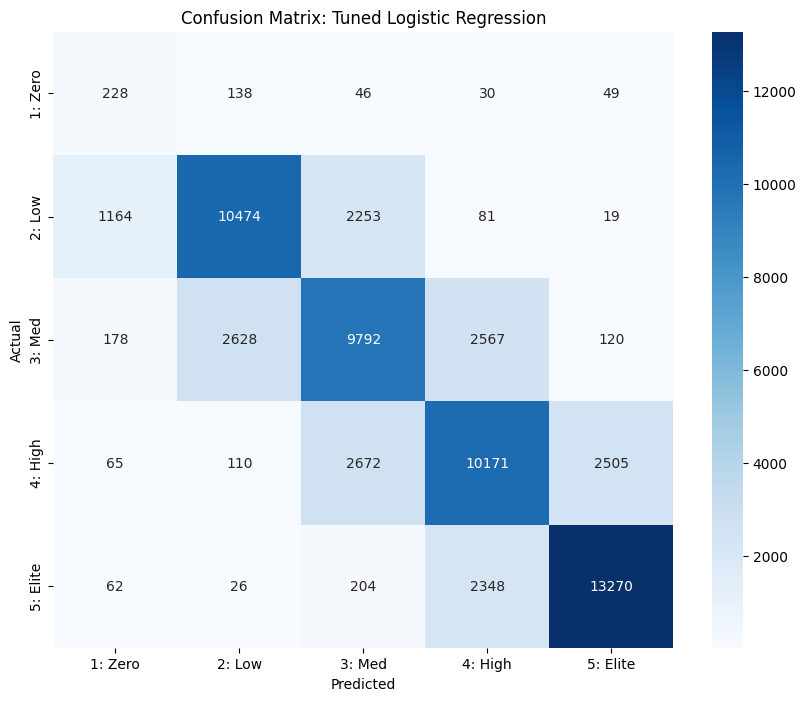

In [17]:
# 1. Print the best parameters found
print("Best parameters found:")
print(random_search_cv.best_params_)
print("-" * 40)

# 2. Print the best cross-validation score
print(f"Best CV Score (Accuracy): {random_search_cv.best_score_:.2%}")
print("-" * 40)

# 3. Evaluate the single BEST model on the blind test data
# The search object automatically uses the best estimator it found
best_model = random_search_cv.best_estimator_
y_pred = best_model.predict(X_test)

# 4. Final Evaluation Report
print("Test Set Evaluation Report:")
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print(classification_report(y_test, y_pred))

# 5. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1: Zero', '2: Low', '3: Med', '4: High', '5: Elite'],
            yticklabels=['1: Zero', '2: Low', '3: Med', '4: High', '5: Elite'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Tuned Logistic Regression')
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3979717731.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', fontsize=12)


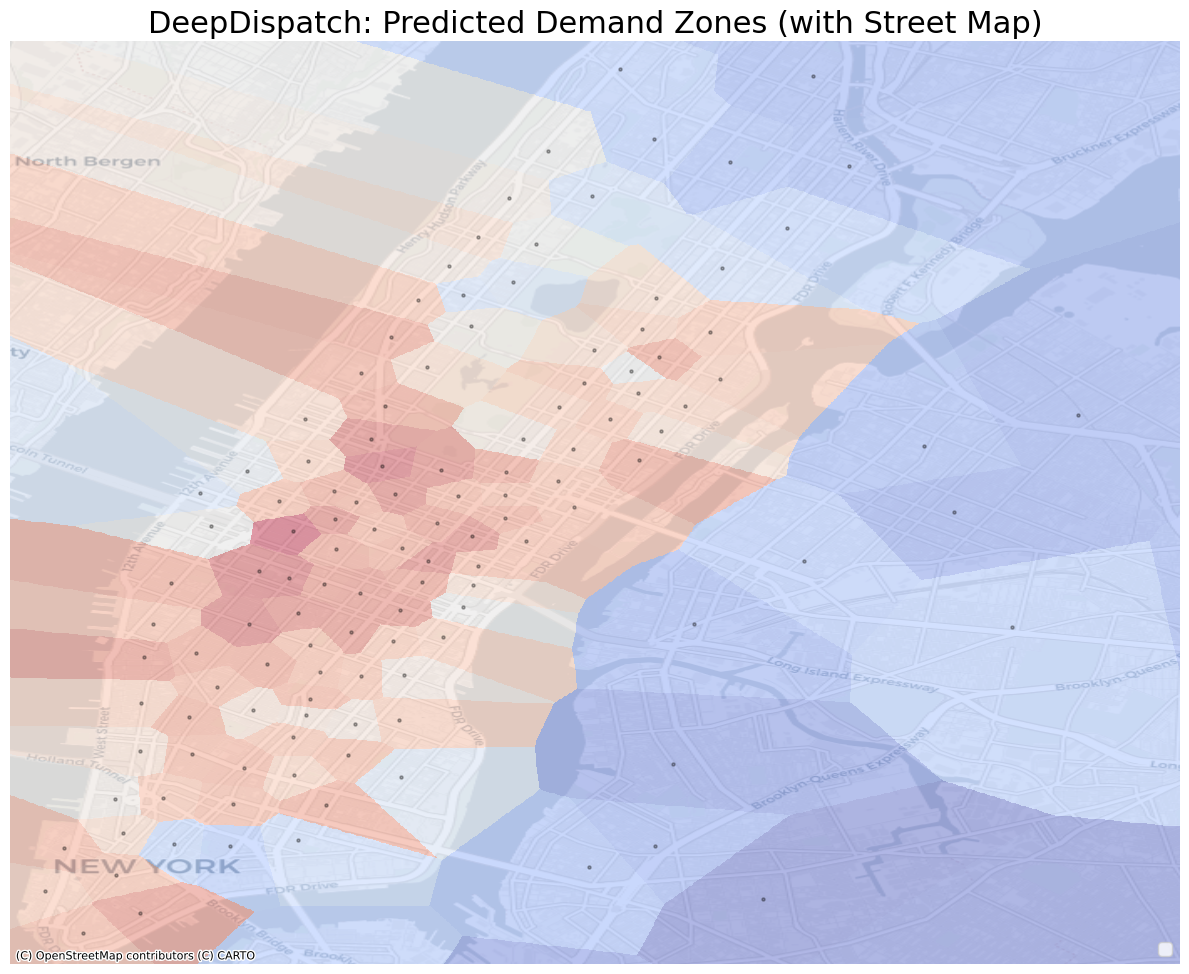

In [18]:
!pip install contextily
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import joblib
import contextily as cx # The Map Library

# --- 1. SETUP & DATA PREP ---
models_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_models/'
kmeans = joblib.load(models_path + 'kmeans_model_k150.pkl')
spatial_scaler = joblib.load(models_path + 'spatial_scaler.pkl')

# Get Predictions
y_pred = best_model.predict(X_test)
viz_df = test_df[['pickup_cluster']].copy()
viz_df['Predicted_Class'] = y_pred

# Map: Cluster ID -> Average Predicted Class
pred_map = viz_df.groupby('pickup_cluster')['Predicted_Class'].mean().to_dict()

# --- 2. GENERATE HIGH-RES GRID (Fixes Jaggedness) ---
# We convert Lat/Lon to "Web Mercator" (EPSG:3857) because Map Tiles use meters, not degrees.
def to_mercator(lon, lat):
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x / lon
    y = 180.0 / np.pi * np.log(np.tan(np.pi / 4.0 + lat * (np.pi / 180.0) / 2.0)) * scale
    return x, y

# Define bounds (NYC)
x_min, x_max = -74.02, -73.90
y_min, y_max = 40.70, 40.82
resolution = 0.0001  # <--- 5x Higher Resolution = Smooth Edges

# Create the Grid in GPS coordinates
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, resolution),
    np.arange(y_min, y_max, resolution)
)

# Flatten and Scale for the Model Prediction
grid_points = np.c_[yy.ravel(), xx.ravel()]
grid_points_scaled = spatial_scaler.transform(grid_points)

# Check type and predict
required_dtype = kmeans.cluster_centers_.dtype
grid_clusters = kmeans.predict(grid_points_scaled.astype(required_dtype))

# Color pixels by Profit
v_pred_map = np.vectorize(lambda x: pred_map.get(x, 0))
Z_pred = v_pred_map(grid_clusters).reshape(xx.shape)

# Convert Grid to Web Mercator for Plotting
xx_merc, yy_merc = to_mercator(xx, yy)

# --- 3. IDENTIFY HOT SPOTS ---
gps_centers = spatial_scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(gps_centers, columns=['latitude', 'longitude'])
centers_df['pickup_cluster'] = range(150)
centers_df['Predicted_Class'] = centers_df['pickup_cluster'].map(pred_map)

# Filter Elite Clusters
hot_spots = centers_df[centers_df['Predicted_Class'] >= 4.0]

# Calculate Hot Spot Center (in Mercator)
if not hot_spots.empty:
    hot_lon, hot_lat = hot_spots['longitude'].mean(), hot_spots['latitude'].mean()
    hot_x, hot_y = to_mercator(hot_lon, hot_lat)
else:
    hot_x, hot_y = to_mercator(-73.985, 40.758)

# Convert all center points to Mercator for plotting
centers_x, centers_y = to_mercator(centers_df['longitude'], centers_df['latitude'])
hot_spots_x, hot_spots_y = to_mercator(hot_spots['longitude'], hot_spots['latitude'])

# --- 4. PLOT ---
fig, ax = plt.subplots(figsize=(12, 10))

# A. Draw the Regions (High Res) with Transparency
# alpha=0.4 ensures you can see the streets underneath
mesh = ax.pcolormesh(xx_merc, yy_merc, Z_pred, cmap='coolwarm', shading='auto', alpha=0.4)

# B. Add the Real Map (Contextily)
# source can be cx.providers.CartoDB.Positron (clean) or cx.providers.OpenStreetMap.Mapnik (colorful)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# C. Draw Center Dots
ax.scatter(centers_x, centers_y, c='black', s=5, alpha=0.3)


# Clean up axes (Turn off numbers because Mercator numbers are huge/ugly)
ax.set_axis_off()
ax.set_title('DeepDispatch: Predicted Demand Zones (with Street Map)', fontsize=22)
ax.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()